# Neural & Behavioral Modeling - Week 13 (Exercises)
by 李采蓉 b08207042@ntu.edu.tw

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [2]:
# Check GPU status:
import torch as t
t.manual_seed(1)    # for reproduction
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.12.1+cu113
No GPU


## 1 Visualizing the latent space of an autoencoder (4 points)

Please train an autoencoder to project MNIST (training) images to a 2D latent space and visualize how these images are organzed in the latent space, as demonstrated in P.20 of model_13_slides.pdf.

<img src="http://fastforwardlabs.github.io/blog-images/miriam/tableau.1493x693.png" width=80%>


### 1.0 The MNIST Data

In [3]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x7f779e33eee0>)

In [4]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

<ipython-input-4-117ffd2d9de7>:4: DeprecationWarning: invalid escape sequence '\>'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
<ipython-input-4-117ffd2d9de7>:4: DeprecationWarning: invalid escape sequence '\?'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


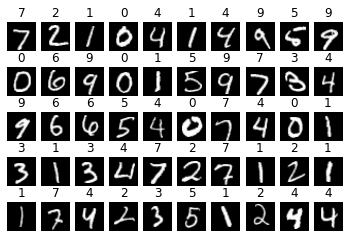

In [5]:
# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')

### 1.1 An autoencoder

In [6]:
import torch.nn as nn
from torch import optim

# Define the network:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2) # 2-dimensional latent space
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [7]:
model=autoencoder()
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)


### 1.2 Your training (2 points)

In [26]:
model = autoencoder()
optimizer = t.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [29]:
# Train
loss_record=[]

for epoch in range(10):
    for i in range(50000):
        inputs = t.tensor(x_train[i]).view(-1, 784)

        # Forward
        codes, decoded = model(inputs)

        # Backward
        optimizer.zero_grad()
        loss = loss_function(decoded, inputs)
        loss.backward()
        optimizer.step()

    # Show progress
    loss_record.append(loss.item())
    print('[{}/{}] Loss:'.format(epoch+1, 10), loss.item())

[1/10] Loss: 0.046108923852443695
[2/10] Loss: 0.04142002761363983
[3/10] Loss: 0.04732847586274147
[4/10] Loss: 0.04101541265845299
[5/10] Loss: 0.040820203721523285
[6/10] Loss: 0.03875318914651871
[7/10] Loss: 0.0696285143494606
[8/10] Loss: 0.04334385693073273
[9/10] Loss: 0.04424693062901497
[10/10] Loss: 0.045307110995054245


### 1.3 Your visualization (2 points)

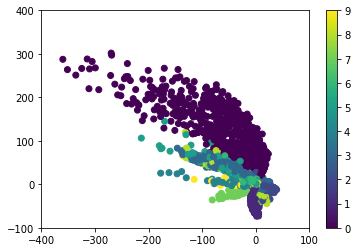

In [61]:
# Please grid-sample the model 2D latent space and visualize the corresponding decoder outputs here
axis_x = []
axis_y = []
answers = []

x_pro=[]

with t.no_grad():
    for i in range(10000):
        inputs = t.tensor(x_test[i]).view(-1, 784)

        code, outputs = model(inputs)
        x_pro.append(outputs.detach().numpy())
        axis_x += code[:, 0].tolist()
        axis_y += code[:, 1].tolist()

xlim(-400, 100)
ylim(-100, 400)
scatter(axis_x, axis_y, c=y_test)
colorbar()
show()

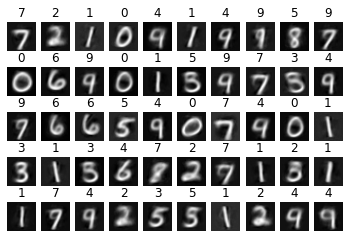

In [63]:
# Examine the reult:
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_pro[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')

**結論**：<br>
4跟9、3跟5，似乎訓練出來的效果不好

## 2 Integer Factorization (4 points)

Here we explore the possibilty that a neural network may be able to judge whether an input integer is a prime number or not.

* Computational problem: tell if an input is a prime number 

* Network Input: an integer in binary code (e.g., 0→000000000000000 (15 bits); 1→000000000000001; 2→000000000000010)

* Network Output: 1 unit (1=yes; 0=no)

* Network Architecture: your choice

* Data set: You can enlarge your training and testing data sets, if necessary. Training accuracies and testing accuraces are both informative but of course we care more about the testing ones.

### 2.1 The data set

In [124]:
from math import sqrt; from itertools import count, islice

def isPrime(n):
    return n > 1 and all(n%i for i in islice(count(2), int(sqrt(n)-1)))

ifPrime=np.vectorize(isPrime)    

x=np.arange(32768) #2^15
y=ifPrime(x).astype(int) 

# Training-testing splits:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# Training data:
print(x_train.shape,x_train)
print(y_train.shape,y_train)

# Testing data:
print(x_test.shape,x_train)
print(y_test.shape,y_train)

# Conversion of an integer to its binary code:
format(x_train[0], '015b') # 15-dimensional feature vector

(26214,) [18328 18509  2161 ... 17080  4499 12669]
(26214,) [0 0 1 ... 0 0 0]
(6554,) [18328 18509  2161 ... 17080  4499 12669]
(6554,) [0 0 1 ... 0 0 0]


'100011110011000'

### 2.2 Your computational experiments (2 points)

In [125]:
x_train_re=[]

for n in x_train:
  number=[]
  x=format(x_train[0], '015b')
  for i in range(15):
    number.append(float(x[i]))
  x_train_re.append(number)

x_test_re=[]

for n in x_test:
  number=[]
  x=format(x_test[0], '015b')
  for i in range(15):
    number.append(float(x[i]))
  x_test_re.append(number)

In [141]:
y_train_re=[]

for n in y_train:
  if n==0:
    y_train_re.append([1.,0.])
  else:
    y_train_re.append([0.,1.])

y_test_re=[]

for n in y_test:
  if n==0:
    y_test_re.append([1.,0.])
  else:
    y_test_re.append([0.,1.])

In [179]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(15, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

        
    def forward(self, input):
        x=self.layer(input)
        m=nn.Sigmoid()
        return m(x)

In [192]:
# Please train & evaluate your model here.
model = NN()
optimizer = optim.RMSprop(model.parameters())
criterion = nn.BCELoss()

x_train_re=t.tensor(x_train_re)
x_test_re=t.tensor(x_test_re)
y_train_re=t.tensor(y_train_re)
y_test_re=t.tensor(y_test_re)

for epoch in range(10):
  train_loss=0
  train_acc=0
  net=model.train()
  for i in range(26214):
    #forward
    output=net(x_train_re[i])
    loss=criterion(output, y_train_re[i])
    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.data.item()
    if output.equal(y_train_re[i]):
      train_acc += 1

  if x_test_re is not None:
    valid_loss=0
    valid_acc=0
    net=net.eval()
    for i in range(6554):
      output=net(x_test_re[i])
      loss=criterion(output, y_test_re[i])
      valid_loss+=loss.data.item()
      if output.int().equal(y_test_re[i].int()):
        valid_acc += 1
    epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, " %
                  (epoch+1, train_loss/26214,
                  train_acc/26214, valid_loss/6554,
                  valid_acc/6554))
  else:
    epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                  (epoch+1, train_loss / 26214,
                  train_acc / 6554))
  print(epoch_str)

<ipython-input-192-268927f703ef>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_re=t.tensor(x_train_re)
<ipython-input-192-268927f703ef>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_re=t.tensor(x_test_re)
<ipython-input-192-268927f703ef>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_re=t.tensor(y_train_re)
<ipython-input-192-268927f703ef>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Epoch 1. Train Loss: 10.761451, Train Acc: 0.892348, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 2. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 3. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 4. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 5. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 6. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 7. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 8. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 9. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 
Epoch 10. Train Loss: 10.761425, Train Acc: 0.892386, Valid Loss: 8.872990, Valid Acc: 0.894568, 


### 2.3 Your discussion (2 points)

Please explain why your model prediction accuracy is better than chance but worse than perfect.

最大的原因是「兩邊資料不平衡」，我們先撇開分類，這樣講會比較簡單，在32768以下的質數總共有3512個，這只佔了所有資料的10%，更不用說假如沒有打散得很好，導致訓練資料內質數和非質數的佔比差距更大，使學習效果大打折扣。

0.89在這個模型當中看起來已經是極限了，假若要更好的話，或許可以先試著將質數和非質數的數量做平衡，之後再看看其他的模型修改方式。

而且我得說明一下，他確實是有在學習的，看看epoch 1和epoch 2的train_acc就可以知道他真的有差，只是後面就沒有進步了。